In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import binance as bnb
from dotenv import load_dotenv
import requests
import json
import os

load_dotenv()

True

In [2]:
def get_coins_data():
    url = "https://www.binance.com/bapi/apex/v1/friendly/apex/marketing/complianceSymbolList"
    response = requests.get(url)
    json_data = json.loads(response.text)

    coin_data = []
    for i in range(len(json_data['data'])):
        try:
            coin_info = {
                'Coin': json_data['data'][i].get('name', 'N/A'),
                'Symbol': json_data['data'][i].get('baseAsset', 'N/A'),
                'Circulating Supply': json_data['data'][i].get('circulatingSupply', 0),
                'Max Supply': json_data['data'][i].get('maxSupply', 0),
                'Total Supply': json_data['data'][i].get('totalSupply', 0),
                'Price': json_data['data'][i].get('price', 0),
                'Market Cap': json_data['data'][i].get('marketCap', 0)
            }
            
            # Add tags as separate columns
            tags = json_data['data'][i].get('tags', [])
            for tag in tags:
                coin_info[f'Tag_{tag}'] = True
                
            coin_data.append(coin_info)
        except Exception as e:
            print(f"Error processing coin at index {i}: {e}")

    # Create DataFrame
    coins_df = pd.DataFrame(coin_data)

    # Fill NaN values in tag columns with False
    tag_columns = [col for col in coins_df.columns if col.startswith('Tag_')]
    coins_df[tag_columns] = coins_df[tag_columns].fillna(False)
    return coins_df

def get_history():
    history = pd.read_csv('history.csv')
    return history

In [3]:
# Get tag columns once to avoid repeated filtering
history = get_history()
coins_df = get_coins_data()
history['Coin']= history.Coin.apply(lambda x: x.replace('USDT',''))
final_df = history.merge(coins_df, on = 'Coin', how = 'left')
final_df[final_df['Tag_defi'] == True]

tag_columns = [col for col in final_df.columns if 'Tag' in col]

# Use inplace operations where possible to avoid copies
temp_df = final_df.copy()
temp_df = temp_df[['dateTime']+tag_columns]
temp_df.fillna(0, inplace=True)
temp_df[tag_columns] = temp_df[tag_columns].astype(int)
temp_df['rowsum'] = temp_df[tag_columns].sum(axis=1)
# Normalize the tag columns by dividing each value by the row sum
# This is a fast vectorized operation that works well for large dataframes
temp_df[tag_columns] = temp_df[tag_columns].div(temp_df['rowsum'], axis=0)
temp_df = temp_df[['dateTime']+tag_columns].groupby('dateTime').sum()
temp_df['rowsum'] = temp_df[tag_columns].sum(axis=1)
temp_df[tag_columns] = temp_df[tag_columns].div(temp_df['rowsum'], axis=0)

history['Coin']= history.Coin.apply(lambda x: x.replace('USDT',''))
final_df = history.merge(coins_df, on = 'Coin', how = 'left')
final_df['Market Cap'] = final_df['close'] * final_df['Circulating Supply']
market_cap_by_day = final_df.groupby(['dateTime']).agg({'Market Cap': 'sum'}).reset_index().rename(columns = {'Market Cap': 'Market Cap Total'})

temp_df = temp_df.merge(market_cap_by_day, on = 'dateTime', how = 'left').drop(columns = ['rowsum'])
temp_df[tag_columns] = temp_df[tag_columns].multiply(temp_df['Market Cap Total'], axis=0)
temp_df


/var/folders/zg/dk0qffx55tj5q4d2hvpp5m2c0000gn/T/ipykernel_76368/4293428954.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  coins_df[tag_columns] = coins_df[tag_columns].fillna(False)


,dateTime,Tag_Meme,Tag_Seed,Tag_bnbchain,Tag_Launchpool,Tag_defi,Tag_Polkadot,Tag_Layer1_Layer2,Tag_Gaming,Tag_Payments,...,Tag_Metaverse,Tag_Monitoring,Tag_Launchpad,Tag_liquid_staking,Tag_pow,Tag_storage-zone,Tag_RWA,Tag_Megadrop,Tag_newListing,Market Cap Total
0,2024-05-28 00:00:00,4.324021e+10,2.283713e+11,6.500350e+10,1.165481e+11,4.332612e+11,2.290872e+10,4.968329e+11,7.960780e+10,6.013539e+10,...,3.235857e+10,6.400124e+10,9.363940e+10,3.149949e+10,1.345887e+11,4.366975e+10,4.653334e+10,2.863590e+09,0.000000e+00,2.534277e+12
1,2024-05-29 00:00:00,4.267409e+10,2.253814e+11,6.415244e+10,1.150222e+11,4.275888e+11,2.260879e+10,4.903282e+11,7.856555e+10,5.934808e+10,...,3.193492e+10,6.316331e+10,9.241343e+10,3.108709e+10,1.328266e+11,4.309801e+10,4.592411e+10,2.826099e+09,0.000000e+00,2.501097e+12
2,2024-05-30 00:00:00,4.278158e+10,2.259491e+11,6.431403e+10,1.153119e+11,4.286658e+11,2.266574e+10,4.915632e+11,7.876344e+10,5.949756e+10,...,3.201535e+10,6.332240e+10,9.264620e+10,3.116539e+10,1.331612e+11,4.320656e+10,4.603978e+10,2.833217e+09,0.000000e+00,2.507397e+12
3,2024-05-31 00:00:00,4.249055e+10,2.244120e+11,6.387652e+10,1.145275e+11,4.257497e+11,2.251155e+10,4.882192e+11,7.822763e+10,5.909282e+10,...,3.179756e+10,6.289164e+10,9.201595e+10,3.095338e+10,1.322553e+11,4.291264e+10,4.572658e+10,2.813944e+09,0.000000e+00,2.490340e+12
4,2024-06-01 00:00:00,4.275489e+10,2.258081e+11,6.427390e+10,1.152400e+11,4.283983e+11,2.265160e+10,4.912565e+11,7.871429e+10,5.946044e+10,...,3.199538e+10,6.328290e+10,9.258840e+10,3.114594e+10,1.330781e+11,4.317960e+10,4.601105e+10,2.831449e+09,0.000000e+00,2.505833e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2025-05-23 00:00:00,8.984003e+10,4.197258e+11,1.045772e+11,2.013607e+11,4.839175e+11,2.267256e+10,5.489595e+11,9.635840e+10,5.951548e+10,...,3.372544e+10,7.184369e+10,9.692521e+10,3.500077e+10,1.332013e+11,4.321957e+10,5.597289e+10,8.785618e+09,2.536493e+10,3.179827e+12
361,2025-05-24 00:00:00,9.025783e+10,4.216777e+11,1.050635e+11,2.022971e+11,4.861679e+11,2.277800e+10,5.515123e+11,9.680650e+10,5.979225e+10,...,3.388228e+10,7.217779e+10,9.737595e+10,3.516354e+10,1.338208e+11,4.342056e+10,5.623319e+10,8.826475e+09,2.548289e+10,3.194615e+12
362,2025-05-25 00:00:00,9.109409e+10,4.255847e+11,1.060370e+11,2.041715e+11,4.906724e+11,2.298904e+10,5.566222e+11,9.770344e+10,6.034624e+10,...,3.419620e+10,7.284653e+10,9.827816e+10,3.548934e+10,1.350606e+11,4.382287e+10,5.675420e+10,8.908255e+09,2.571899e+10,3.224213e+12
363,2025-05-26 00:00:00,9.107303e+10,4.276410e+11,1.060125e+11,2.062790e+11,4.905590e+11,2.298373e+10,5.564936e+11,9.768085e+10,6.248702e+10,...,3.418830e+10,7.282969e+10,9.825544e+10,3.548113e+10,1.350294e+11,4.381273e+10,5.674108e+10,8.906195e+09,2.786777e+10,3.232087e+12


In [7]:
timeseries_df = temp_df.melt(id_vars = ['dateTime','Market Cap Total'], value_vars = tag_columns, var_name = 'Tag', value_name = 'Market Cap by Tag')
timeseries_df['Percentage'] = timeseries_df['Market Cap by Tag'] / timeseries_df['Market Cap Total']
timeseries_df.drop(columns = ['Market Cap by Tag','Market Cap Total'], inplace = True)


timeseries_df = timeseries_df[timeseries_df['Percentage']>0.1]
pivot_df = timeseries_df[['dateTime','Tag','Percentage']].pivot(index='dateTime', columns='Tag', values='Percentage')

# Create the interactive plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a Plotly figure
fig = px.line(pivot_df.reset_index(), x='dateTime', y=pivot_df.columns,
              title='Tag Percentage Over Time',
              labels={'value': 'Percentage', 'variable': 'Tag'},
              markers=True)  # Add markers to the lines

# Customize the layout
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Percentage',
    legend_title='Tags',
    hovermode='x unified',
    template='plotly_white',
    height=600,
    width=1000
)

# Add hover information
fig.update_traces(
    hovertemplate='<b>%{y:.2%}</b><extra></extra>'
)

# Format y-axis as percentage
fig.update_layout(yaxis_tickformat='.1%')

# Show the plot
fig.show()


In [8]:
# Filter coins with Tag_Seed
coins_df
seed_coins = coins_df[coins_df['Tag_Seed'] == True]

# # Calculate market cap for each coin (using close price)


# # Sort by market cap and get top 10 for better visualization
top_seed_coins = seed_coins.sort_values('Market Cap', ascending=False).head(10)
other_market_cap = seed_coins.iloc[20:]['Market Cap'].sum() if len(seed_coins) > 10 else 0

# # Create data for pie chart
labels = list(top_seed_coins['Coin'])
if other_market_cap > 0:
    labels.append('Others')
    
values = list(top_seed_coins['Market Cap'])
if other_market_cap > 0:
    values.append(other_market_cap)

# Create pie chart
fig = px.pie(
    names=labels,
    values=values,
    title='Market Cap Distribution of Seed Coins',
    hole=0.4,
)

# Customize layout
fig.update_layout(
    legend_title="Coins",
    width=900,
    height=700
)

# Format hover text to show values in billions/millions
fig.update_traces(
    textinfo='percent+label',
    hovertemplate='<b>%{label}</b><br>Market Cap: $%{value:,.0f}<br>Percentage: %{percent}<extra></extra>'
)

# Show the chart
fig.show()

/var/folders/zg/dk0qffx55tj5q4d2hvpp5m2c0000gn/T/ipykernel_76368/4293428954.py:33: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



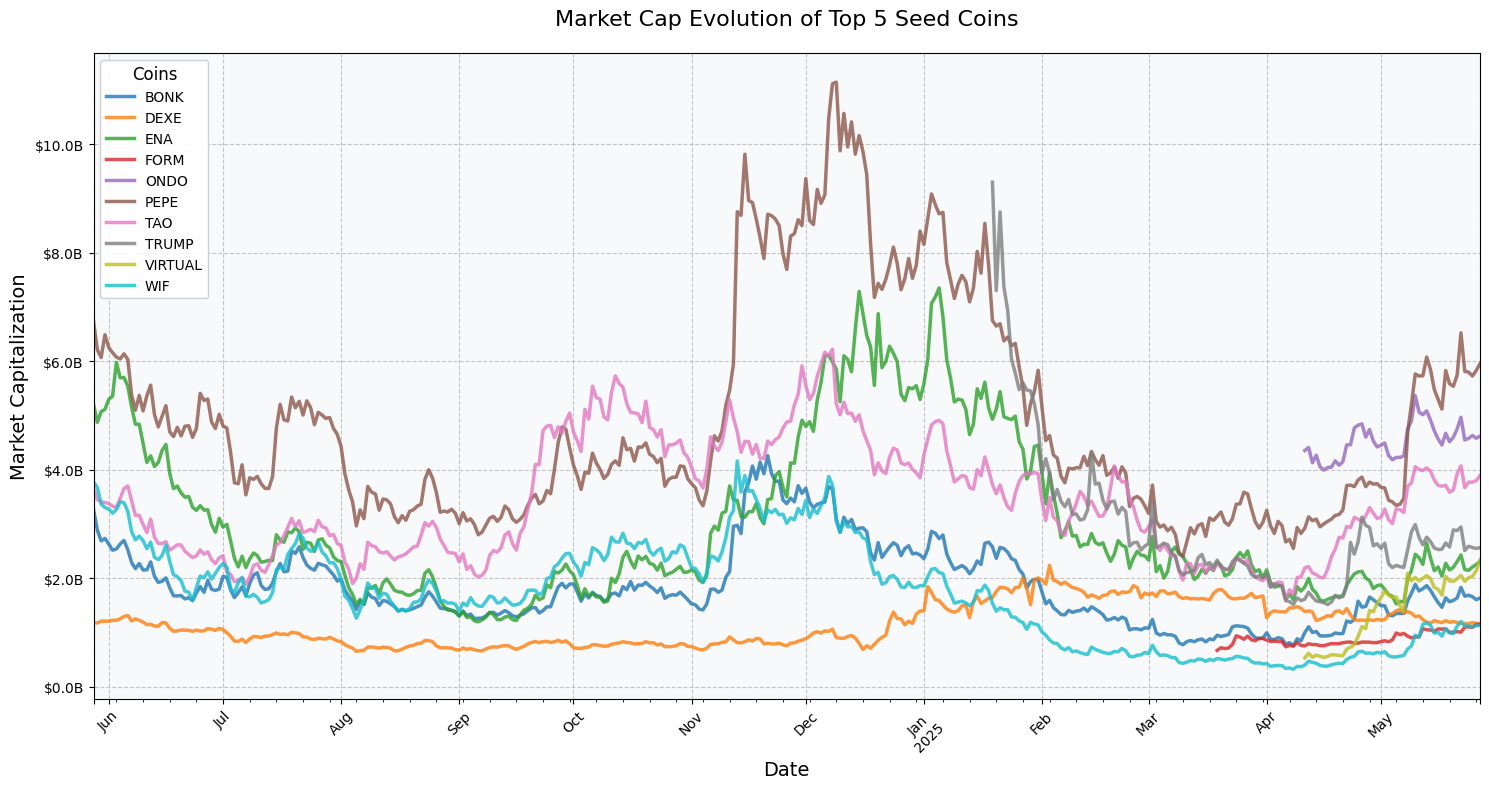

In [9]:
def get_top_coins(category, top_n = 10, coins_df = get_coins_data()):
    coins_df = coins_df[coins_df[category] == True]
    top_10_coins = coins_df.sort_values('Market Cap', ascending=False).head(top_n)
    return top_10_coins

# Get top 5 DeFi coins
top = get_top_coins('Tag_Seed', top_n = 10)[['Coin','Circulating Supply']]
top = history[history['Coin'].isin(top['Coin'])].merge(top, on = 'Coin', how = 'left')
top['Market Cap'] = top['Circulating Supply'] * top['close']
top = top[['dateTime','Coin','Market Cap']]
top['dateTime'] = pd.to_datetime(top['dateTime'], format='%Y-%m-%d %H:%M:%S')

# Create a better looking plot
plt.figure(figsize=(15, 8))
ax = plt.gca()

# Plot the data with improved styling
pivot_data = top.pivot(index='dateTime', columns='Coin', values='Market Cap')
pivot_data.plot(ax=ax, linewidth=2.5, alpha=0.8)

# Format y-axis to show billions
def billions_formatter(x, pos):
    return f'${x/1e9:.1f}B'
ax.yaxis.set_major_formatter(plt.FuncFormatter(billions_formatter))

# Improve the styling
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Market Cap Evolution of Top 5 Seed Coins', fontsize=16, pad=20)
plt.ylabel('Market Capitalization', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Coins', title_fontsize=12, fontsize=10, loc='upper left', frameon=True, facecolor='white', framealpha=0.9)

# Add some padding
plt.tight_layout()

# Add a subtle background color
ax.set_facecolor('#f8f9fa')



In [10]:
temp = coins_df[coins_df['Tag_Seed'] == True]
thresholds = [
    (0, 1_000_000, '<$1M'),
    (1_000_000, 10_000_000, '$1M-$10M'),
    (10_000_000, 50_000_000, '$10M-$50M'),
    (50_000_000, 100_000_000, '$50M-$100M'),
    (100_000_000, 500_000_000, '$100M-$500M'),
    (500_000_000, 1_000_000_000, '$500M-$1B'),
    (1_000_000_000, 5_000_000_000, '$1B-$5B'),
    (5_000_000_000, 10_000_000_000, '$5B-$10B'),
    (10_000_000_000, 50_000_000_000, '$10B-$50B'),
    (50_000_000_000, float('inf'), '>$50B')
]
def categorize_market_cap(cap):
    for low, high, label in thresholds:
        if low <= cap < high:
            return label
    return '>$10B'  # Default for very large caps

temp['Market Cap'].apply(categorize_market_cap)

0       $50M-$100M
1      $100M-$500M
2      $100M-$500M
4      $100M-$500M
7        $10M-$50M
          ...     
378    $100M-$500M
379        $1B-$5B
383    $100M-$500M
397      $500M-$1B
398      $500M-$1B
Name: Market Cap, Length: 150, dtype: object

In [11]:
# Create a function to analyze market cap distribution for any tag
def analyze_market_cap_distribution(tag=None, coins_df=get_coins_data()):
    """
    Analyze the market cap distribution of coins in a specific tag category.
    
    Parameters:
    - tag: The tag category to analyze (e.g., 'Tag_Seed', 'Tag_Meme')
    - coins_df: DataFrame containing coin data
    
    Returns:
    - DataFrame with market cap distribution analysis
    """
    # Filter by tag if specified
    if tag:
        filtered_df = coins_df[coins_df[tag] == True].copy()
    else:
        filtered_df = coins_df.copy()
    
    # Define market cap thresholds
    thresholds = [
        (0, 1_000_000, '<$1M'),
        (1_000_000, 10_000_000, '$1M-$10M'),
        (10_000_000, 50_000_000, '$10M-$50M'),
        (50_000_000, 100_000_000, '$50M-$100M'),
        (100_000_000, 500_000_000, '$100M-$500M'),
        (500_000_000, 1_000_000_000, '$500M-$1B'),
        (1_000_000_000, 5_000_000_000, '$1B-$5B'),
        (5_000_000_000, 10_000_000_000, '$5B-$10B'),
        (10_000_000_000, 50_000_000_000, '$10B-$50B'),
        (50_000_000_000, float('inf'), '>$50B')
    ]
    
    # Categorize coins by market cap
    def categorize_market_cap(cap):
        for low, high, label in thresholds:
            if low <= cap < high:
                return label
        return '>$10B'  # Default for very large caps
    
    filtered_df['Market Cap Category'] = filtered_df['Market Cap'].apply(categorize_market_cap)
    
    # Count coins in each category
    distribution = filtered_df.groupby('Market Cap Category').size().reset_index(name='Count')
    
    # Calculate percentages
    total_coins = distribution['Count'].sum()
    distribution['Percentage'] = (distribution['Count'] / total_coins * 100).round(2)
    
    # Ensure the categories are in the right order
    category_order = ['<$1M', '$1M-$10M', '$10M-$50M', '$50M-$100M', '$100M-$500M', '$500M-$1B', '$1B-$5B', '$5B-$10B', '$10B-$50B', '>$50B']
    distribution['Market Cap Category'] = pd.Categorical(
        distribution['Market Cap Category'], 
        categories=category_order, 
        ordered=True
    )
    distribution = distribution.sort_values('Market Cap Category')
    
    return distribution, filtered_df

# Create interactive widgets for tag selection
import ipywidgets as widgets
from IPython.display import display

# Get all tag columns
tag_columns = [col for col in get_coins_data().columns if col.startswith('Tag_')]
tag_options = [None] + tag_columns  # Add None option for all coins

# Create dropdown for tag selection
tag_dropdown = widgets.Dropdown(
    options=tag_options,
    description='Category:',
    value=tag_options[1]  # Default to first tag
)

# Function to update visualizations based on selected tag
def update_visualizations(tag):
    distribution, filtered_df = analyze_market_cap_distribution(tag)
    
    # Create a figure with subplots
    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "pie"}, {"type": "bar"}]],
        subplot_titles=("Market Cap Distribution (%)", "Number of Coins by Market Cap")
    )
    
    # Add pie chart
    fig.add_trace(
        go.Pie(
            labels=distribution['Market Cap Category'],
            values=distribution['Percentage'],
            textinfo='label+percent',
            hoverinfo='label+percent+value',
            marker=dict(line=dict(color='#000000', width=1)),
            hole=0.4
        ),
        row=1, col=1
    )
    
    # Add bar chart
    fig.add_trace(
        go.Bar(
            x=distribution['Market Cap Category'],
            y=distribution['Count'],
            text=distribution['Percentage'],
            textposition='auto',
            hovertemplate='%{x}<br>Count: %{y}<br>Percentage: %{text:.2f}%',
            marker_color='royalblue'
        ),
        row=1, col=2
    )
    
    # Update layout
    title_text = f"Market Cap Distribution for {tag.replace('Tag_', '')} Coins" if tag else "Market Cap Distribution for All Coins"
    fig.update_layout(
        title_text=title_text,
        height=600,
        width=1200,
        showlegend=True,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    
    # Display the figure
    fig.show();
    
    # Display the distribution table
    display(distribution)

# Create interactive widget
interactive_plot = widgets.interactive(update_visualizations, tag=tag_dropdown)
display(interactive_plot);

# Initialize with default tag
update_visualizations(tag_options[1]);

/var/folders/zg/dk0qffx55tj5q4d2hvpp5m2c0000gn/T/ipykernel_76368/4293428954.py:33: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/var/folders/zg/dk0qffx55tj5q4d2hvpp5m2c0000gn/T/ipykernel_76368/4293428954.py:33: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



interactive(children=(Dropdown(description='Category:', index=1, options=(None, 'Tag_Meme', 'Tag_Seed', 'Tag_b…

,Market Cap Category,Count,Percentage
2,$10M-$50M,2,7.41
5,$50M-$100M,5,18.52
0,$100M-$500M,12,44.44
4,$500M-$1B,2,7.41
3,$1B-$5B,3,11.11
6,$5B-$10B,2,7.41
1,$10B-$50B,1,3.70


In [ ]:
analysis_df = final_df[[
    'dateTime',
    'Coin',
    'Market Cap'
]+tag_columns]
seed_df = analysis_df[analysis_df['Tag_Seed'] == True]
coin = seed_df[seed_df['Coin'] == 'OM']
# Use .loc to avoid SettingWithCopyWarning
# Create a copy of the dataframe to avoid SettingWithCopyWarning
coin = coin.copy()
coin.loc[:, 'Next Market Cap'] = coin.loc[:, 'Market Cap'].shift(-1)
coin = coin[['dateTime','Market Cap','Next Market Cap']]
coin['is_Billion'] = coin['Market Cap'] > 1_000_000_000
coin.loc[:,'next_is_Billion'] = coin['Next Market Cap'] > 1_000_000_000
# Concatenate is_Billion and next_is_Billion columns
coin.dropna(inplace=True)
coin['is_Billion'] = coin['is_Billion'].astype(str) + '->' + coin['next_is_Billion'].astype(str)
coin[coin.is_Billion.isin(['True->False','False->True'])]

## De-BTCing

In [ ]:
import warnings
import pandas as pd
import numpy as np
from tqdm import tqdm
warnings.filterwarnings('ignore')

df = pd.read_csv('history.csv')
df = df[['Coin','dateTime','open','close']]
final_df = pd.DataFrame()
for coin in tqdm(df['Coin'].unique(), desc="Processing coins"):
    temp_df = df[df.Coin == coin]
    temp_df['open_pct'] = np.round(temp_df['open'].pct_change()*100,2)
    temp_df['close_pct'] = np.round(temp_df['close'].pct_change()*100,2)
    # Apply moving average smoothing to percentage changes
    # Default window size of 7 days for weekly smoothing
    window_size = 7
    
    # Create smoothed versions of the percentage changes
    temp_df['open_pct_smooth'] = temp_df['open_pct'].rolling(window=window_size, min_periods=1).mean()
    temp_df['close_pct_smooth'] = temp_df['close_pct'].rolling(window=window_size, min_periods=1).mean()
    
    # Fill any NaN values that might be created at the beginning of the series
    temp_df['open_pct_smooth'] = temp_df['open_pct_smooth'].fillna(temp_df['open_pct'])
    temp_df['close_pct_smooth'] = temp_df['close_pct_smooth'].fillna(temp_df['close_pct'])
    final_df = pd.concat([final_df, temp_df])

    

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns

# Clean data
final_df = final_df.dropna()
analysis = final_df.copy()
n_days = 365

# Extract BTC data
btc = analysis[analysis.Coin == 'BTCUSDT']
btc.drop(columns=['Coin', 'open', 'close'], inplace=True)

# Extract non-BTC data
nonbtc = analysis[~(analysis.Coin == 'BTCUSDT')].drop(columns=['open', 'close'])

# Merge datasets
joined = nonbtc.merge(btc, on='dateTime', suffixes=['', '_btc'])



# Calculate BTC-independent price movements
joined['de_btcfied_open'] = joined['open_pct'] - joined['open_pct_btc']
joined['de_btcfied_close'] = joined['close_pct_smooth'] - joined['close_pct_smooth_btc']




# Plot improved charts
plt.style.use('seaborn-v0_8-darkgrid')

# Create a single figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Selected coins to plot
selected_coins = [i for i in joined.Coin.unique() if joined.tail(n_days)[joined.Coin == i]['de_btcfied_close'].mean() > 0]
# Filter out coins with less than 10 datapoints
coin_counts = joined.groupby('Coin').size()
coins_with_enough_data = coin_counts[coin_counts >= 10].index.tolist()

# Only keep coins that have enough data points
selected_coins = [coin for coin in selected_coins if coin in coins_with_enough_data]

# Print the number of coins before and after filtering
print(f"Coins before filtering: {len([i for i in joined.Coin.unique() if joined.tail(n_days)[joined.Coin == i]['de_btcfied_close'].mean() > 0.1])}")
print(f"Coins after filtering (min 10 datapoints): {len(selected_coins)}")

# Plot each coin on the same axes
for coin in selected_coins:
    plotdata = joined[joined.Coin == coin].tail(n_days)
    
    # Convert dateTime to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(plotdata['dateTime']):
        plotdata['dateTime'] = pd.to_datetime(plotdata['dateTime'])
    
    # Plot with label for legend
    ax.plot(plotdata['dateTime'], plotdata['de_btcfied_close'], linewidth=2, label=coin)

# Improve formatting
ax.set_title(f'BTC-Independent Price Movement Comparison', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('De-BTCfied Close (%)', fontsize=12)

# Format x-axis dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Add legend
ax.legend(title='Coins', loc='best')

# Add grid and tight layout
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [ ]:
# Create a new figure for the bell curves (normal distribution plots)
plt.figure(figsize=(10, 6))

# For each selected coin, plot its distribution
for coin in selected_coins:
    # Get the data for this coin
    coin_data = joined[joined.Coin == coin]['de_btcfied_close'].dropna().tail(n_days)
    plt.hist(coin_data, bins=5, alpha=0.5, label=coin, density=True)

# Improve formatting
plt.title('Distribution of BTC-Independent Price Movements', fontsize=14)
plt.xlabel('De-BTCfied Close (%)', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Add legend
plt.legend(title='Coins', loc='best')

# Add grid and tight layout
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()
